In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from dataclasses import dataclass
import os

# Setup 

## Modifiable

In [3]:
class Gradient_Estimation():

    def gradient_theta(theta, X):
        '''

        Estimate gradient with respect to theta given random input (vectorized across reps)

        theta: decision-vector for each rep  (n_rep, d_theta)
        X: random elements (n_rep, d_X)

        return: gradient estimate (n_rep, d_theta)

        '''

class Tilting():
    def sample():
        '''

        Sample random elements (vectorized across reps)
        n_rep: number of reps
        return: random elements (n_rep, d_X)

        '''

    def sample_IS(mu):
        '''
        Sample random elements for IS (vectorized across reps)
        mu: tilting parameter for each rep  (n_rep, d_mu)
        n_rep: number of reps
        return: random elements (n_rep, d_X)

        '''

    def likelihood_ratio(mu, X_IS):
        '''
        Compute likelihood ratio for IS (vectorized across reps)
        mu: tilting parameter for each rep  (n_rep, d_mu)
        X_IS: random elements (n_rep, d_X)
        return: likelihood ratio (n_rep,)
        '''
    

    def gradient_likelihood(mu, X):
        '''

        get gradient of likelihood function with respect to mu (vectorized across reps)

        mu: tilting parameter for each rep  (n_rep, d_mu)
        X: random elements (n_rep, d_X)

        return: gradient of the likelihood function with respect to mu (n_rep, d_mu)

        '''









## Helper functions & Algorithms

In [4]:
def gradient_theta_IS(grad_scheme, tilt_scheme, theta, mu, X_IS):
    '''
    Estimate gradient with respect to theta using IS (vectorized across reps)

    grad_scheme: instance of Gradient_Estimation
    tilt_scheme: instance of Tilting
    theta: decision-vector for each rep  (n_rep, d_theta)
    mu: tilting parameter for each rep  (n_rep, d_mu)
    X_IS: random elements for IS (n_rep, d_X)

    return: gradient estimate with IS (n_rep, d_theta)

    '''

    return tilt_scheme.likelihood_ratio(mu, X_IS)[:, np.newaxis] * grad_scheme.gradient_theta(theta, X_IS)


def gradient_mu_IS(grad_scheme, tilt_scheme, theta, mu, X):

    '''
    Gradient of IS estimator with respect to mu (vectorized across reps)
    grad_scheme: instance of Gradient_Estimation
    tilt_scheme: instance of Tilting
    theta: decision-vector for each rep  (n_rep, d_theta)
    mu: tilting parameter for each rep  (n_rep, d_mu)
    X: random elements (n_rep, d_X)
    return: gradient estimate with IS (n_rep, d_mu)

    '''
    grad = grad_scheme.gradient_theta(theta, X)  # shape (n_rep, d_theta)
    grad_norm = np.sum(grad**2, axis=1)     # shape (n_rep,)
    grad_likelihood = tilt_scheme.gradient_likelihood(mu, X)  # or (n_rep, d_theta)
    
    return grad_norm[:, np.newaxis] * grad_likelihood

In [5]:
def box_projection(input,upper, lower):

    '''
    Box projection

    input: input vector (n_rep, d)
    upper: upper bound vector (d,)
    lower: lower bound vector (d,)

    return: projected vector (n_rep, d)

    '''
    return np.minimum(np.maximum(input, lower), upper)

# Algorithm 


def projected_sgd(config, grad_scheme, tilt_scheme, theta0):

    '''
    perform projected stochastic gradient descent
    config: ExperimentConfig instance
    grad_scheme: instance of Gradient_Estimation
    tilt_scheme: instance of Tilting
    theta0: initial decision-vector (d_theta,)

    return: result (n_rep, d_theta, n_step)

    '''
    # config 
    gamma = config.gamma
    alpha = config.alpha
    n_rep = config.n_rep
    n_step = config.n_step
    n_rep = config.n_rep
    theta_upper = config.theta_upper
    theta_lower = config.theta_lower
    d_theta = config.d_theta


    # store
    theta = np.repeat(theta0[np.newaxis, :], n_rep, axis=0)
    result = np.zeros((n_rep, d_theta, n_step))

    # SGD loop
    for step in range(n_step):
        alpha_step = alpha/ ((step+1) ** gamma)
        X = tilt_scheme.sample() # initial random elements (n_rep, d_X)
        grad_theta = grad_scheme.gradient_theta(theta, X)
        theta = box_projection(theta - alpha_step * grad_theta,theta_upper, theta_lower)

        result[:, :, step] = theta

    return result


def nda(config, grad_scheme, tilt_scheme, theta0):
    '''

    Perform Nesterov dual averaging

    config: ExperimentConfig instance
    grad_scheme: instance of Gradient_Estimation
    tilt_scheme: instance of Tilting
    theta0: initial decision-vector (d_theta,)

    return: result (n_rep, d_theta, n_step)

    '''
    # config 
    gamma = config.gamma
    alpha = config.alpha
    n_rep = config.n_rep
    n_step = config.n_step
    n_rep = config.n_rep
    theta_upper = config.theta_upper
    theta_lower = config.theta_lower
    d_theta = config.d_theta


    # store
    theta = np.repeat(theta0[np.newaxis, :], n_rep, axis=0)
    result = np.zeros((n_rep, d_theta, n_step))
    g_sum = np.zeros((n_rep, d_theta))

    # NDA loop
    for step in range(n_step):
        alpha_step = alpha/ ((step+1) ** gamma)
        X = tilt_scheme.sample()
        grad_theta = grad_scheme.gradient_theta(theta, X)
        g_sum += alpha_step *grad_theta

        theta = box_projection(theta0 - g_sum, theta_upper, theta_lower)
        result[:, :, step] = theta

    return result


def nda_IS(config, grad_scheme, tilt_scheme, theta0, mu0):
    ''' 
    Perform Nesterov dual averaging with importance sampling

    config: ExperimentConfig instance
    grad_scheme: instance of Gradient_Estimation
    tilt_scheme: instance of Tilting
    theta0: initial decision-vector (d_theta,)
    mu0: initial tilting parameter (d_mu,)
    
    
    return: result (n_rep, d_theta, n_step)
    '''

    # config 
    gamma = config.gamma
    alpha = config.alpha
    alpha_mu = config.alpha_mu
    n_rep = config.n_rep
    n_step = config.n_step
    n_rep = config.n_rep
    theta_upper = config.theta_upper
    theta_lower = config.theta_lower
    mu_upper = config.mu_upper
    mu_lower = config.mu_lower
    d_theta = config.d_theta
    d_mu = config.d_mu


    # store
    theta = np.repeat(theta0[np.newaxis, :], n_rep, axis=0)
    mu = np.repeat(mu0[np.newaxis, :], n_rep, axis=0)
    result_theta = np.zeros((n_rep, d_theta, n_step))
    result_mu = np.zeros((n_rep, d_mu, n_step))
    g_sum_theta = np.zeros((n_rep, d_theta))
    g_sum_mu = np.zeros((n_rep, d_mu))

    # NDA loop
    for step in range(n_step):
        alpha_step = alpha/ ((step+1) ** gamma)
        alpha_mu_step = alpha_mu/ ((step+1) ** gamma)
        X_IS = tilt_scheme.sample_IS(mu)
        X = tilt_scheme.sample()
        grad_theta = gradient_theta_IS(grad_scheme, tilt_scheme, theta, mu, X_IS)
        grad_mu = gradient_mu_IS(grad_scheme, tilt_scheme, theta, mu, X)
        # print("grad_mu", np.linalg.norm(grad_mu, axis=1).mean())

        g_sum_theta += alpha_step *grad_theta
        g_sum_mu += alpha_mu_step *grad_mu # scale to avoid too large updates
        # print("alpha_mu_step", alpha_mu_step)
        # print("g_sum_mu", np.linalg.norm(g_sum_mu, axis=1).mean())

        theta = box_projection(theta0 - g_sum_theta, theta_upper, theta_lower)
        mu = box_projection(mu0 - g_sum_mu, mu_upper, mu_lower)

        result_theta[:, :, step] = theta
        result_mu[:, :, step] = mu

    return result_theta, result_mu
    


These functions are for some interrogation and some sanity check

In [6]:
def plot_trajectory(single_result): 

    '''

    Plot trajectory of decision vector (taking only one replication)

    single_result: result from optimization algorithm ( d_theta, n_step)

    plot: the trajectory of each parameter in d_theta together in one plot as n lines
    '''
    d_theta = single_result.shape[0]
    n_step = single_result.shape[1]
    for i in range(d_theta):
        plt.plot(range(n_step), single_result[i, :], label=f'Theta {i+1}')
    plt.xlabel('Step')
    plt.ylabel('Parameter Value')
    plt.title('Trajectory of Decision Vector Parameters')
    plt.legend()
    plt.show()


## Visualization & Inspection

In [7]:
def plot_norm_deviate(results):
    '''

    take results from different algorithm and plot norm of deviate 

    results: dictionary of results from different algorithms
             key: algorithm name
             value: result (n_rep, d_theta, n_step)

    plot norm of deviate over iterations for each algorithm with confidence interval
    
    '''
    plt.figure()
    for key in results.keys():
        result = results[key]
        n_rep = result.shape[0]
        n_step = result.shape[2]
        norm_deviate = np.linalg.norm(result - result[:, :, -1][:, :, np.newaxis], axis=1)  # shape (n_rep, n_step)
        mean_norm_deviate = np.mean(norm_deviate, axis=0)
        std_norm_deviate = np.std(norm_deviate, axis=0)
        ci_upper = mean_norm_deviate + 1.96 * std_norm_deviate / np.sqrt(n_rep)
        ci_lower = mean_norm_deviate - 1.96 * std_norm_deviate / np.sqrt(n_rep)

        plt.plot(mean_norm_deviate, label=key)
        plt.fill_between(range(n_step), ci_lower, ci_upper, alpha=0.2)

    plt.xlabel('Iteration')
    plt.ylabel('Norm of Deviate')
    plt.legend()
    plt.title('Norm of Deviate over Iterations')
    plt.show()

    

def plot_theta(results, true_theta = None,  type = "theta", avg = False, save_path = None ):

    '''

    take results from different algorithm and plot theta
    also take a one single number true theta to plot as reference if provided with a red dashed line 
    results: dictionary of results from different algorithms
             key: algorithm name
             value: result (n_rep, d_theta, n_step)
    plot theta over iterations for each algorithm with confidence interval
    printed separately for each parameter in d_theta

    '''
    
    plt.figure(figsize=(7, 7))
    for key in results.keys():
        result = results[key]
        n_rep = result.shape[0]
        n_step = result.shape[2]
        d_theta = result.shape[1]
        


        if avg == True:
            result = np.cumsum(result, axis=2) / (np.arange(1, n_step + 1)[np.newaxis, np.newaxis, :])  # shape (n_rep, d_theta, n_step)
            if save_path is not None:
                save_path = save_path.replace('.pdf', '_avg.pdf')

        for i in range(d_theta):
            theta_i = result[:, i, :]  # shape (n_rep, n_step)
            mean_theta_i = np.mean(theta_i, axis=0)
            std_theta_i = np.std(theta_i, axis=0)

            # 95% confidence interval find the upper and lower bounds empirical quantiles
            
            
            # ci_upper = mean_theta_i + 1.96 * std_theta_i 
            # ci_lower = mean_theta_i - 1.96 * std_theta_i 

            ci_lower = np.quantile(theta_i, 0.1, axis=0)
            ci_upper = np.quantile(theta_i, 0.9, axis=0)


            plt.plot(mean_theta_i, label=f'{key}')
            plt.fill_between(range(n_step), ci_lower, ci_upper, alpha=0.2)
            print(f'{key} - Theta {i+1} final value: {mean_theta_i[-1]:.4f} ± {1.96 * std_theta_i[-1] / np.sqrt(n_rep):.4f}')

        
    if true_theta is not None:
        if type == "mu":
            plt.axhline(y=true_theta, color='r', linestyle='--', label=rf'$\mu^*$')
        else:
            plt.axhline(y=true_theta, color='r', linestyle='--', label=rf'$\theta^*$')
        

    plt.xlabel(rf'Iteration $n$')

    if type == "mu":
        
        plt.ylim(0, 2)
        plt.ylabel(r'$\bar{\mu}_n$' if avg else r'$\mu_n$')
    else:
        plt.ylim(3.5, 8.5)
        
        plt.ylabel(r'$\bar{\theta}_n$' if avg else r'$\theta_n$')
        
    plt.legend()
    # plt.title('Theta Parameters over Iterations')
    

    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
        print(f"Figure saved to {save_path}")
        
    plt.show()
    


In [59]:
def plot_avg_variance(results, asym_variance=None, burn_in=0, save_path=None):
    plt.figure(figsize=(7, 7))

    for key, result in results.items():
        n_rep, d_theta, n_step = result.shape

        x = result[:, :, burn_in:]  # drop burn-in
        T = x.shape[2]
        theta_bar = np.cumsum(x, axis=2) / np.arange(1, T + 1)[None, None, :]

        var_theta_bar = np.var(theta_bar, axis=0).mean(axis=0) * np.arange(1, T + 1)
        plt.plot(np.arange(burn_in + 1, burn_in + T + 1), var_theta_bar, label=key)

    if asym_variance is not None:
        plt.axhline(y=asym_variance, color='r', linestyle='--', label=rf'$\Sigma^*_G$')

    plt.xlabel(r'Iteration $n$')
    plt.ylabel(r'$Variance\  of\  \sqrt{n}(\bar{\theta_n} - \theta^*)$')
    plt.legend()

    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
        print(f"Figure saved to {save_path}")

    plt.show()


In [9]:
def find_optimal_variance(config,grad_scheme,  tilt_scheme, theta_opt, n_grid = 100):
    ''' 
    grid search over all the box of the tilting parameter to find the optimal asymptotic variance
    config: ExperimentConfig instance
    tilt_scheme: instance of Tilting
    n_grid: number of grid points per dimension
    theta_opt: optimal decision vector (d_theta,)

    return: optimal asymptotic variance (float)
    '''

    d_mu = config.d_mu
    mu_lower = config.mu_lower
    mu_upper = config.mu_upper

    grid_axes = [np.linspace(mu_lower[i], mu_upper[i], n_grid) for i in range(d_mu)]

    mesh = np.meshgrid(*grid_axes)

    mu_grid = np.vstack([m.flatten() for m in mesh]).T  # shape (n_grid**d_mu, d_mu)
    min_variance = float('inf')
    min_mu = None
    for mu in mu_grid:
        print("mu", mu)
        mu_tile = np.tile(mu[np.newaxis, :], (10000,1))
        theta_opt_tile = np.tile(theta_opt[np.newaxis, :], (10000,1))
        X_IS = tilt_scheme.sample_IS(mu_tile)
        grad_theta = gradient_theta_IS(grad_scheme, tilt_scheme, theta_opt_tile, mu_tile, X_IS) # shape (n_rep, d_theta)
        variance = np.var(np.linalg.norm(grad_theta, axis=1))
        if variance < min_variance:
            min_variance = variance
            min_mu = mu

    print("min_mu:", min_mu)    

    return min_variance 








## Experiments 

In [10]:
def experiment_1(config, grad_scheme, tilt_scheme, theta0, mu0):
    '''

    Run experiment 1 comparing different algorithms

    config: ExperimentConfig instance
    grad_scheme: instance of Gradient_Estimation
    tilt_scheme: instance of Tilting
    theta0: initial decision-vector (d_theta,)
    mu0: initial tilting parameter (d_mu,)

    return: results dictionary
            key: algorithm name
            value: result (n_rep, d_theta, n_step)

    '''
    results = {}
    results_mu = {}

    # Projected SGD
    results['Projected SGD'] = projected_sgd(config, grad_scheme, tilt_scheme, theta0)

    # Nesterov Dual Averaging
    results['NDA'] = nda(config, grad_scheme, tilt_scheme, theta0)

    # Nesterov Dual Averaging with IS
    result_theta, result_mu = nda_IS(config, grad_scheme, tilt_scheme, theta0, mu0)
    results['NDA with IS']  = result_theta
    results_mu['NDA with IS'] = result_mu

    
    return results, results_mu

## Common Tilting Schemes

In [11]:

class Normal_Expo_Tilting(Tilting):
    '''

    Tilting scheme for multivariate standard normal distribution with exponential tilting
    
    d_X: dimension of random input
    n_rep: number of repetitions

    
    '''
    def __init__(self, config):
        self.d_X = config.d_X
        self.n_rep = config.n_rep
        np.random.seed(config.seed)

    def sample(self):
        return np.random.normal(0, 1, (self.n_rep, self.d_X))

    def sample_IS(self, mu):
        # mu is (n_rep, d_mu) and d_mu = d_X
        return np.random.normal(mu, 1)

    def likelihood_ratio(self, mu, X_IS):
        # mu is (n_rep, d_mu) and d_mu = d_X
        exponent = 0.5 * np.sum(mu**2, axis=1) - np.sum(mu * X_IS, axis=1)
        return np.exp(exponent)

    def gradient_likelihood(self, mu, X):
        # mu is (n_rep, d_mu) and d_mu = d_X
        return (mu- X)* self.likelihood_ratio(mu, X)[:, np.newaxis]






## Experiment Config

In [12]:
@dataclass
class ExperimentConfig:
    n_rep: int         # number of repetitions
    n_step: int       # number of iterations
    d_X: int          # dimension of random input
    d_theta: int      # dimension of theta
    d_mu: int         # dimension of mu
    alpha: float      # step size
    gamma: float      # decay rate
    alpha_mu: float # step size for mu
    seed: int     # random seed

    theta_upper: np.ndarray  # shape (d_theta,)
    theta_lower: np.ndarray  # shape (d_theta,)
    mu_upper: np.ndarray     # shape (d_mu,)
    mu_lower: np.ndarray     # shape (d_mu,)


# Toy setting

## Experiment configuration

In [51]:
d_X =1
mu_bound = 1.7
config = ExperimentConfig(
    n_rep=1000,
    n_step = 200000, 
    # n_step=10000,
    d_X=d_X,
    d_theta=1,
    d_mu=1,
    alpha=.05,
    alpha_mu = 0.000003, 
    gamma=0.55,
    seed=42,

    
    theta_upper=np.ones(1) * 1000.0,
    theta_lower=np.ones(1) * (-100.0),
    mu_upper=np.ones(d_X) * mu_bound,
    mu_lower=np.ones(d_X) * (-mu_bound),
    
)

In [14]:
# port folio config
@dataclass
class ToyConfig:
    p: float # quantile 

toy_config = ToyConfig(p =0.9999 )

In [15]:
class Toy_Grad_Estimation(Gradient_Estimation):
    '''

    Gradient estimation scheme for CVaR objective

    d_theta: dimension of theta
    n_rep: number of repetitions
    alpha_cvar: CVaR level

    '''
    def __init__(self, port_config: ToyConfig):
        self.config = port_config
        self.p = port_config.p
        
        self.lamb = 1.0 / (1.0 - port_config.p)

        

    def gradient_theta(self, theta, X):
        '''
        Estimate stochastic gradient with respect to theta given random input (vectorized across reps)
        theta: decision-vector for each rep  (n_rep, d_theta)
        X: random elements (n_rep, d_X)
        return: gradient estimate (n_rep, d_theta)

        '''

        n_rep = X.shape[0]

        # grad = 1. - self.lamb * (X >= theta).astype(float)  # shape (n_rep, d_theta)

        grad = 1. - self.lamb * (X >= theta).astype(float)  # shape (n_rep, d_theta)

        return grad     # shape (n_rep, d_theta)




In [40]:
def find_asym_variance(toy_config, grad_scheme, tilt_scheme, mu_opt):
    '''

    Find asymptotic variance at optimal theta

    return: \hessian^2 f(\theta) *var_{x_IS}(G_mu^*(\theta, X_IS))*\hessian^2 f(\theta)

    '''
    # optimal theta
    n_eval = 10000000
    theta_opt = norm.ppf(toy_config.p)

    mu_opt_ar = np.array([[mu_opt]]*n_eval)
    theta_opt_ar = np.array([[theta_opt]]*n_eval)

    # compute asymptotic variance
    lamb = 1.0 / (1.0 - toy_config.p)
    pdf_theta = norm.pdf(theta_opt)

    X_IS = tilt_scheme.sample_IS(mu_opt_ar)

    grad_theta = gradient_theta_IS(grad_scheme, tilt_scheme, theta_opt_ar, mu_opt_ar, X_IS)


    asym_variance = np.var(grad_theta)/( lamb * pdf_theta )**2
    
    print(asym_variance)
    return asym_variance

In [41]:
asym_variance = find_asym_variance(toy_config, toy_grad_scheme, ET_scheme, mu_bound)

4.5364255831713525


## Sanity Check

In [16]:
# X_san = np.random.normal(0, 1, (1000000)) 

quantile_9 =  norm.ppf(0.9)
print("0.9 quantile is: ", quantile_9)

quantile_99 = norm.ppf(0.99)
print("0.99 quantile is: ", quantile_99)

quantile_999 = norm.ppf(0.999)
print("0.999 quantile is: ", quantile_999)


quantile_9999 = norm.ppf(0.9999)
print("0.9999 quantile is: ", quantile_9999)

0.9 quantile is:  1.2815515655446004
0.99 quantile is:  2.3263478740408408
0.999 quantile is:  3.090232306167813
0.9999 quantile is:  3.719016485455709


## Experiment 1: Almost sure convergence

In [17]:
ET_scheme = Normal_Expo_Tilting(config)
toy_grad_scheme = Toy_Grad_Estimation(toy_config)

In [18]:
# asym_var = find_optimal_variance(config, toy_grad_scheme, ET_scheme, np.array([quantile_9999]), n_grid=100)

In [52]:
results_theta_1, results_mu_1 = experiment_1(config,
                     toy_grad_scheme,
                      ET_scheme, 
                      theta0=np.ones(config.d_theta)*(7.), 
                      mu0=np.ones(config.d_mu)*(.2))

# plot_theta(results_theta_1)
# plot_theta(results_mu_1)

In [384]:
# plot_theta(results_theta_1, true_theta=quantile_9999, type="theta", save_path="results/exp1/toy_theta_sd_100.pdf")
# plot_theta(results_mu_1, type="mu", save_path="results/exp1/toy_mu_sd_100.pdf")

Projected SGD - Theta 1 final value: 3.9664 ± 0.0236
NDA - Theta 1 final value: 3.9588 ± 0.0213
NDA with IS - Theta 1 final value: 3.7203 ± 0.0018
Figure saved to results/exp1/toy_1.7_theta_sd_100000.pdf


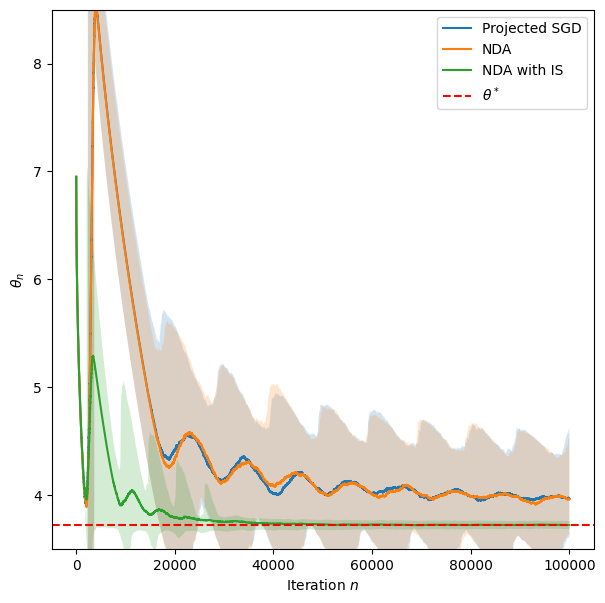

NDA with IS - Theta 1 final value: 1.6923 ± 0.0027
Figure saved to results/exp1/toy_1.7_mu_sd_100000.pdf


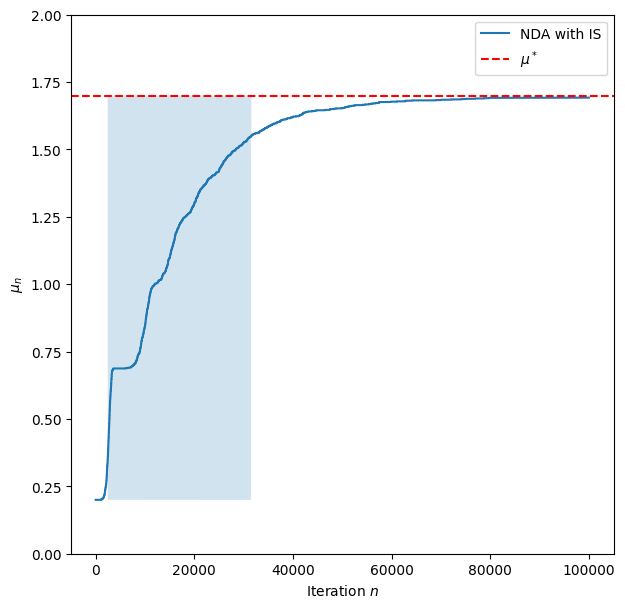

In [24]:
plot_theta(results_theta_1, true_theta=quantile_9999, type="theta", save_path=f"results/exp1/toy_{mu_bound}_theta_sd_{config.n_step}.pdf")
plot_theta(results_mu_1, true_theta=mu_bound,type="mu", save_path=f"results/exp1/toy_{mu_bound}_mu_sd_{config.n_step}.pdf")

Projected SGD - Theta 1 final value: 4.4336 ± 0.0103
NDA - Theta 1 final value: 4.4281 ± 0.0104
NDA with IS - Theta 1 final value: 3.8257 ± 0.0047
Figure saved to results/exp1/toy_1.7_theta_sd_100000_avg_avg_avg.pdf


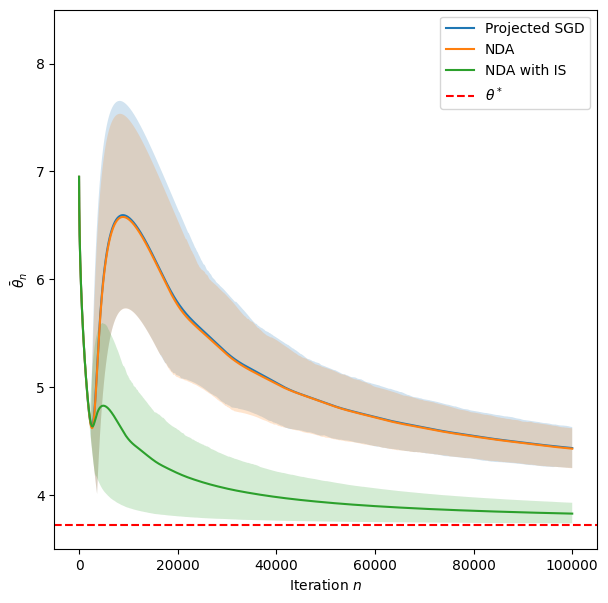

NDA with IS - Theta 1 final value: 1.4758 ± 0.0131
Figure saved to results/exp1/toy_1.7_mu_sd_100000_avg.pdf


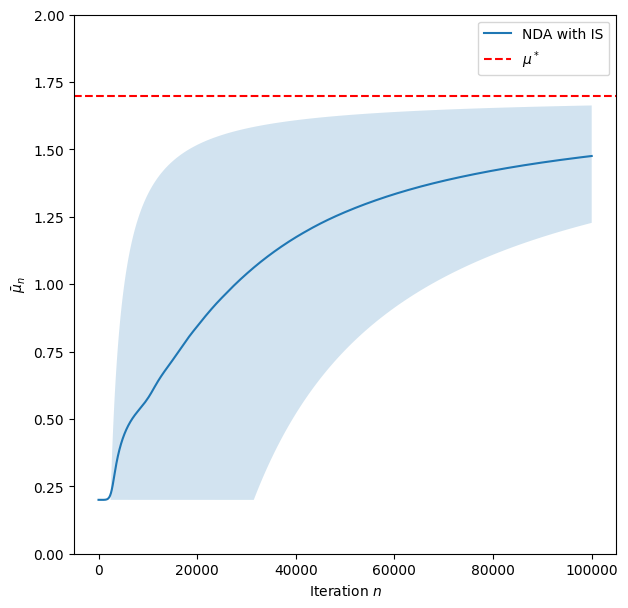

In [25]:
plot_theta(results_theta_1, true_theta=quantile_9999, type="theta", avg= True,  save_path=f"results/exp1/toy_{mu_bound}_theta_sd_{config.n_step}.pdf")
plot_theta(results_mu_1, true_theta=mu_bound,type="mu",avg= True, save_path=f"results/exp1/toy_{mu_bound}_mu_sd_{config.n_step}.pdf")

NDA with IS - Theta 1 final value: 1.1752 ± 0.0132
Figure saved to results/exp1/toy_mu_sd_200_avg.pdf


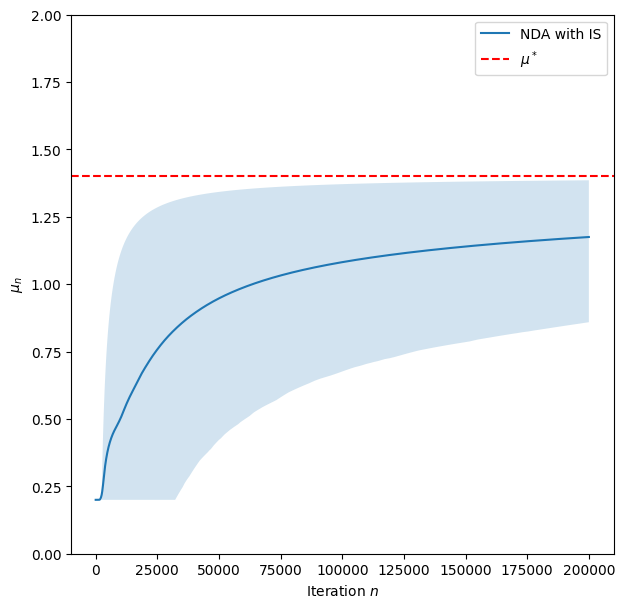

In [373]:
plot_theta(results_mu_1, true_theta=1.4,type="mu",avg= True, save_path="results/exp1/toy_mu_sd_200.pdf")

Figure saved to results/exp3/toy_burn_40000_mu_1.7_step_200000.pdf


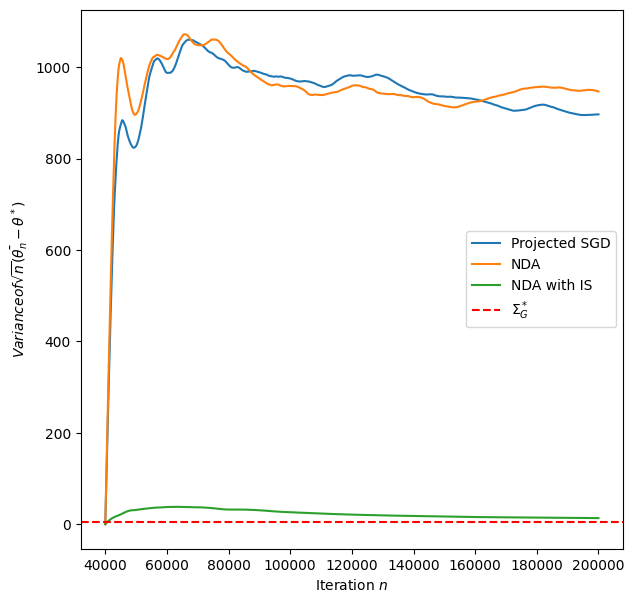

In [60]:
burn_in = 40000
plot_avg_variance(results_theta_1, asym_variance = asym_variance, burn_in=40000, save_path =f"results/exp3/toy_burn_{burn_in}_mu_{mu_bound}_step_{config.n_step}.pdf" )

# CVaR Setup

## Experiment Configurations

In [91]:

n_asset = 2

config = ExperimentConfig(
    n_rep=20,
    n_step = 10000, 
    # n_step=10000,
    d_X=n_asset,
    d_theta=1,
    d_mu=n_asset,
    alpha=1.,
    alpha_mu = 0.0005, 
    gamma=0.6,
    seed=42,

    
    theta_upper=np.ones(1) * 1000.0,
    theta_lower=-np.ones(1) * 100.0,
    mu_upper=np.ones(n_asset) * 20.,
    mu_lower=-np.ones(n_asset) * 20.,
    
)

In [87]:
# port folio config
@dataclass
class PortfolioConfig:
    p: float # quantile 
    r: float # risk-free level
    q: float # dividend rate
    sigma: float
    T: float # time horizon
    S0: float # initial stock price (assume that all assets have the same initial price)
    K: float # strike price
    delta_t: float # risk period
    n_asset: int # number of underlying assets
    n_call: float # number of call options on each asset
    n_put: float # number of put options on each asset
    

port_config = PortfolioConfig(p =0.9,
                                r=0.05,
                                q=0.0,
                                sigma=0.3,
                                T=.5,
                                S0=100.0,
                                K=100.0,
                                delta_t=0.04,
                                n_asset=config.d_X,
                                n_call = 10,
                                n_put = 5
                                )


In [88]:
class Cvar_Grad_Estimation(Gradient_Estimation):
    '''

    Gradient estimation scheme for CVaR objective

    d_theta: dimension of theta
    n_rep: number of repetitions
    alpha_cvar: CVaR level

    '''
    def __init__(self, port_config: PortfolioConfig):
        self.config = port_config
        self.n_asset = port_config.n_asset
        self.n_call = port_config.n_call
        self.n_put = port_config.n_put
        self.S0 = port_config.S0
        self.K = port_config.K
        self.T = port_config.T
        self.r = port_config.r
        self.q = port_config.q
        self.delta_t = port_config.delta_t
        self.sigma = port_config.sigma
        self.lamb = 1.0 / (1.0 - port_config.p)

        

    def gradient_theta(self, theta, X):
        '''
        Estimate stochastic gradient with respect to theta given random input (vectorized across reps)
        theta: decision-vector for each rep  (n_rep, d_theta)
        X: random elements (n_rep, d_X)
        return: gradient estimate (n_rep, d_theta)

        '''

        n_rep = X.shape[0]
        loss = self.portfolio_loss( X)  # shape (n_rep,)
        # make loss ( n_rep, 1)
        loss = loss[:, np.newaxis]

        grad = 1. - self.lamb * (loss >= theta).astype(float)  # shape (n_rep, d_theta)

        return grad     # shape (n_rep, d_theta)


    @staticmethod
    def blsprice(S, K , T, r, q, sigma):
        ''' 
        Black-Scholes price for European call option. For vector S, we assume that each asset has the same K, T, r, q, sigma.
        S: stock price (scalar or vector)
        K: strike price (scalar)
        T: time to maturity (scalar)
        r: risk-free rate (scalar)
        q: dividend rate (scalar)
        sigma: volatility (scalar)

        return: (call, put) with same shape as S (scalar in -> scalar out).
        '''


        S = np.asarray(S, dtype=float)
        
        # check if S is less than 0
        if np.any(S <= 0):
            raise ValueError("Stock price S must be positive.")


        sqrtT = np.sqrt(T)
        d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * sqrtT)
        d2 = d1 - sigma * sqrtT

        disc_r = np.exp(-r * T)
        disc_q = np.exp(-q * T)

        call = S * disc_q * norm.cdf(d1) - K * disc_r * norm.cdf(d2)
        put  = K * disc_r * norm.cdf(-d2) - S * disc_q * norm.cdf(-d1)

        # preserve scalar in -> scalar out
        if call.ndim == 0:
            return call.item(), put.item()
        return call, put



    def portfolio_loss(self,  X):
        '''
        Compute portfolio loss given theta and random elements X
    

        X: random elements (n_rep, d_X)
        return: portfolio loss (n_rep,)
        '''

        call0, put0 = self.blsprice(self.S0, self.K, self.T, self.r, self.q, self.sigma)

        Phi0 = (self.n_call * call0 + self.n_put * put0)* self.n_asset

        C_tilde = self.S0 *np.sqrt(self.delta_t) * self.sigma #( scalar in this case)
        S_X = self.S0 + C_tilde * X # shape (n_rep, d_X)

        call, put = self.blsprice(S_X, self.K, self.T - self.delta_t, self.r, self.q, self.sigma)

        Phi = (self.n_call * np.sum(call, axis = 1) + self.n_put * np.sum(put, axis = 1))  # shape (n_rep,)

        loss = Phi0 -Phi

        return loss

        


### Sanity Check before Start 

Similar to the previous experiments in Safe Start and Adaptive Importance Sampling papers, we expect the 0.9999 and 0.99999 quantiles of this portfolio to be roughly 214 and 233, respectively. The numbers look right. So, there should be no issue with this blsprice implementation. 

In [76]:
# # Sanity Check 

# X_san = np.random.normal(0, 1, (5000000, 10))
# loss_san = Cvar_Grad_Estimation.portfolio_loss(Cvar_Grad_Estimation(port_config), X_san)

# # find p quantile of loss_san where p = 0.999
# quantile_999 = np.quantile(loss_san, 0.999)
# print("0.999 quantile is: ", quantile_999)

# quantile_9999 = np.quantile(loss_san, 0.9999)
# print("0.9999 quantile is: ", quantile_9999)


# quantile_99999 = np.quantile(loss_san, 0.99999)
# print("0.99999 quantile is: ", quantile_99999)

In [78]:
# Sanity Check 

#  d_X = n_asset = 2

X_san = np.random.normal(0, 1, (10000000, config.d_X))
loss_san = Cvar_Grad_Estimation.portfolio_loss(Cvar_Grad_Estimation(port_config), X_san)

# find p quantile of loss_san where p = 0.9
quantile_9 = np.quantile(loss_san, 0.9)
print("0.99 quantile is: ", quantile_9)


# find p quantile of loss_san where p = 0.999
quantile_99 = np.quantile(loss_san, 0.99)
print("0.99 quantile is: ", quantile_99)

# find p quantile of loss_san where p = 0.999
quantile_999 = np.quantile(loss_san, 0.999)
print("0.999 quantile is: ", quantile_999)

quantile_9999 = np.quantile(loss_san, 0.9999)
print("0.9999 quantile is: ", quantile_9999)


quantile_99999 = np.quantile(loss_san, 0.99999)
print("0.99999 quantile is: ", quantile_99999)

0.99 quantile is:  39.107942164866685
0.99 quantile is:  53.60754769499994
0.999 quantile is:  57.40998529172036
0.9999 quantile is:  58.00779646060125
0.99999 quantile is:  58.07565804511151


## Experiment 1: Almost sure convergence

In [89]:

# p 0.9999
# target quantile is around 214
ET_scheme = Normal_Expo_Tilting(config)

cvar_grad_scheme = Cvar_Grad_Estimation(port_config)

Projected SGD - Theta 1 final value: 39.1923 ± 0.1389
Nesterov Dual Averaging - Theta 1 final value: 39.1636 ± 0.1876
NDA with IS - Theta 1 final value: 39.3357 ± 0.1320


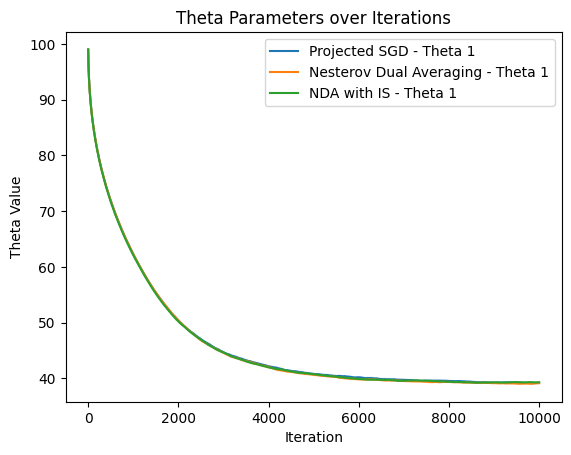

NDA with IS - Theta 1 final value: -0.2675 ± 0.0017
NDA with IS - Theta 2 final value: -0.2686 ± 0.0016


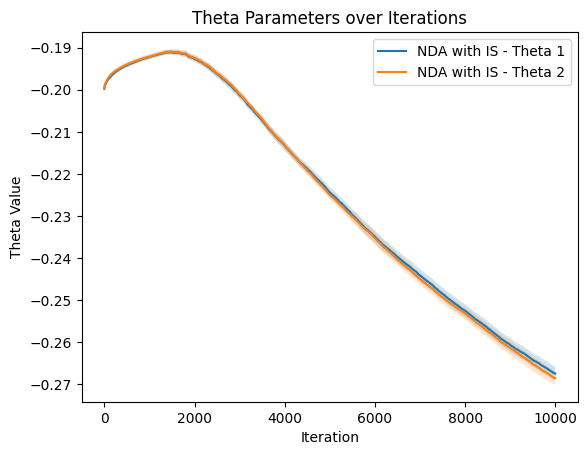

In [92]:
results_theta_1, results_mu_1 = experiment_1(config,
                     cvar_grad_scheme,
                      ET_scheme, 
                      theta0=np.ones(config.d_theta)*100, 
                      mu0=np.ones(config.d_mu)*(-.2))

plot_theta(results_theta_1)
plot_theta(results_mu_1)

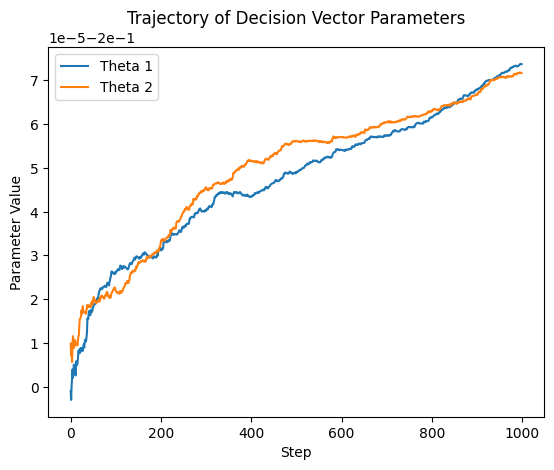

In [73]:
plot_trajectory(results_mu_1['NDA with IS'][0, :, :])

## Experiment 2: Active Constraints

## Experiment 3: Optimal Variance 